## Section 1: การเตรียมข้อมูล (Data Extraction & Features)


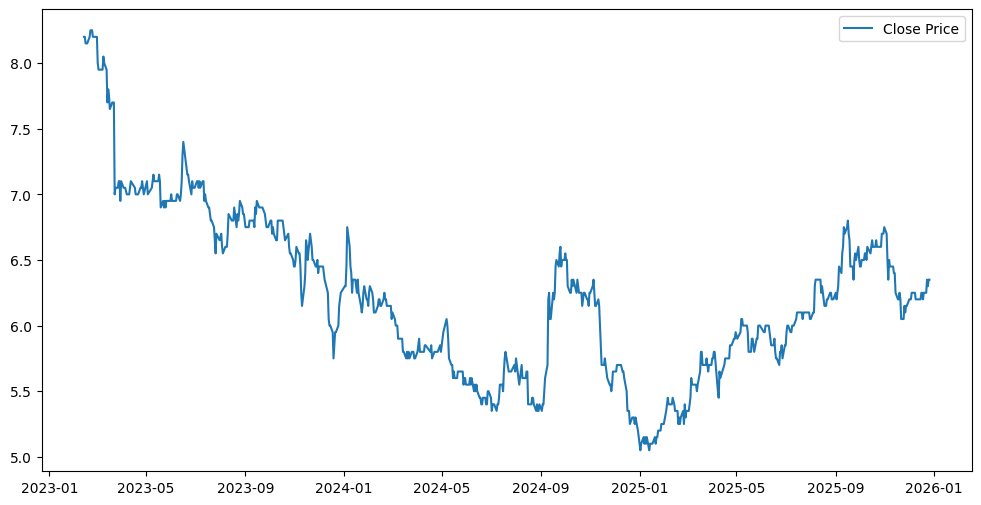

In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from cassandra.cluster import Cluster

# 1.1 ดึงข้อมูล
cluster = Cluster(['127.0.0.1'])
session = cluster.connect('stock_data')
query = "SELECT symbol, date, open, high, low, close, volume FROM candlestick_data WHERE symbol = '3BBIF' ALLOW FILTERING"
df = pd.DataFrame(list(session.execute(query)))

# 1.2 เตรียม Data, RSI และ MACD
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# คำนวณ RSI
df['rsi'] = ta.rsi(df['close'], length=14)

# คำนวณ MACD (จะเกิดคอลัมน์ MACD_12_26_9, MACDh_12_26_9, MACDs_12_26_9)
df.ta.macd(fast=12, slow=26, signal=9, append=True)

# ลบค่า NaN ออก
df = df.dropna().reset_index(drop=True)

# 1.3 พล็อตกราฟเช็คข้อมูลดิบ
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['close'], label='Close Price')
plt.title('')
plt.legend()
plt.show()


## Section 2: การทำ Labeling


In [2]:
from scipy.signal import find_peaks

def label_head_shoulders(prices, distance=15):
    labels = np.zeros(len(prices))
    # หาจุดสูงสุดท้องถิ่น (Local Maxima)
    peaks, _ = find_peaks(prices, distance=distance)
    
    # วนลูปเพื่อหาโครงสร้าง: ยอดซ้าย < หัว > ยอดขวา
    for i in range(1, len(peaks) - 1):
        left_s = prices[peaks[i-1]]
        head = prices[peaks[i]]
        right_s = prices[peaks[i+1]]
        
        if head > left_s and head > right_s:
            # มาร์คตำแหน่งที่ยอดหัว (Head) เป็นคลาส 1
            labels[peaks[i]] = 1
    return labels

df['label'] = label_head_shoulders(df['close'].values)
print(f"จำนวนแพทเทิร์นที่พบ: {df['label'].sum()} จุด")


จำนวนแพทเทิร์นที่พบ: 8.0 จุด


## Section 3: การสร้าง Tensors 


In [3]:
from sklearn.preprocessing import MinMaxScaler

# เลือก Features (ระบุชื่อคอลัมน์ MACD ให้ตรงกับที่ pandas_ta สร้าง)
feature_cols = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'MACD_12_26_9', 'MACDs_12_26_9']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[feature_cols])

WINDOW_SIZE = 60 # ใช้ข้อมูลย้อนหลัง 60 วัน

def create_tensors(data, labels, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i : i + window])
        y.append(labels[i + window])
    return np.array(X), np.array(y)

X, y = create_tensors(scaled_data, df['label'].values, WINDOW_SIZE)

# แบ่ง Train/Test (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


## Section 4: การสร้างและฝึกโมเดล (Deep Learning)


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(WINDOW_SIZE, len(feature_cols))),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # ทายว่าเป็น H&S (1) หรือไม่ (0)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4.2 ฝึกโมเดล
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# ประเมินผลจาก Test Set เพื่อเก็บค่าลงในตัวแปร acc
loss, acc = model.evaluate(X_test, y_test, verbose=0)

# แสดงค่า Train Accuracy (จาก history) และ Test Accuracy
print(f"Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Test Accuracy:  {acc:.4f}")

/Users/hilmanyusoh/Desktop/Stock-market-chart-pattern-recognition-using-deep-learning/stock_pattern/venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
/Users/hilmanyusoh/Desktop/Stock-market-chart-pattern-recognition-using-deep-learning/stock_pattern/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9863 - loss: 0.3525 - val_accuracy: 0.9844 - val_loss: 0.0994
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9882 - loss: 0.0722 - val_accuracy: 0.9844 - val_loss: 0.0846
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9882 - loss: 0.0658 - val_accuracy: 0.9844 - val_loss: 0.0856
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9882 - loss: 0.0675 - val_accuracy: 0.9844 - val_loss: 0.0836
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9882 - loss: 0.0642 - val_accuracy: 0.9844 - val_loss: 0.0838
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9882 - loss: 0.0677 - val_accuracy: 0.9844 - val_loss: 0.0823
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9882 - loss: 0.0664 - val_accuracy: 0.9844 - val_loss: 0.0826
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9882 - loss: 0.0698 - val_accuracy: 0.9844 - v

## Section 5: การประเมินผลความแม่นยำ (Evaluation)


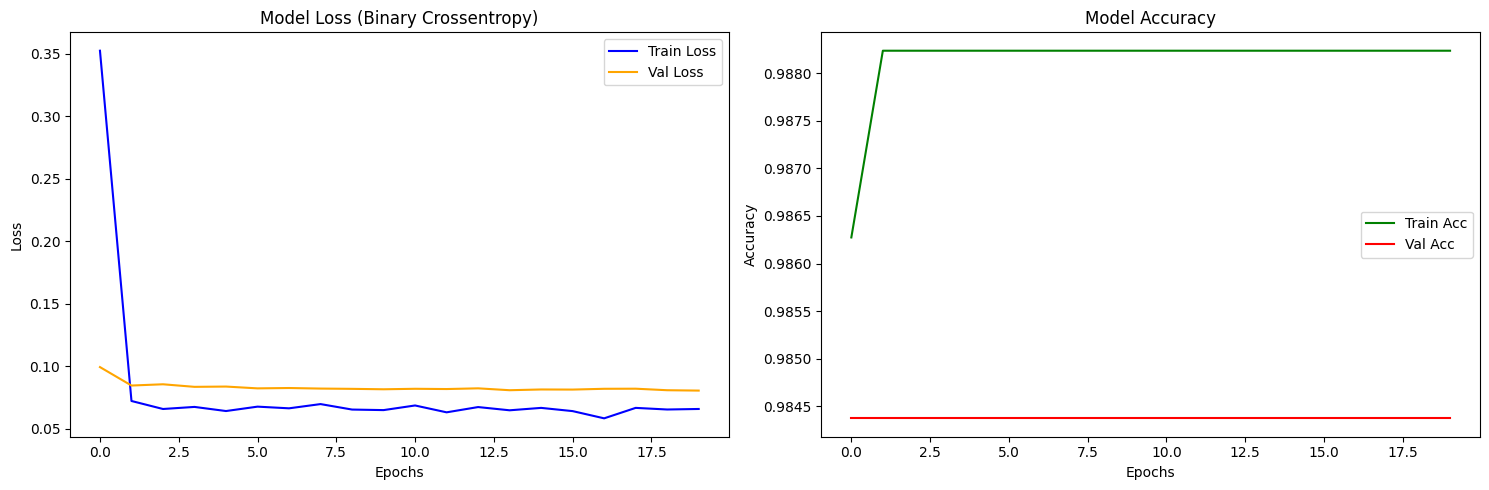

In [5]:
import matplotlib.pyplot as plt

# สร้างพื้นที่สำหรับ 2 กราฟ (ซ้าย-ขวา)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# กราฟ Loss Curve
ax1.plot(history.history['loss'], label='Train Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Val Loss', color='orange')
ax1.set_title('Model Loss (Binary Crossentropy)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# กราฟ Accuracy Curve
ax2.plot(history.history['accuracy'], label='Train Acc', color='green')
ax2.plot(history.history['val_accuracy'], label='Val Acc', color='red')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


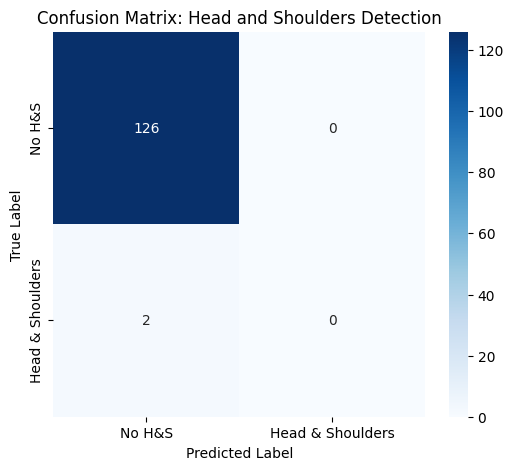

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. ทำนายผลจาก Test Set
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# 2. สร้าง Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# 3. พล็อตกราฟด้วย Seaborn Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No H&S', 'Head & Shoulders'],
            yticklabels=['No H&S', 'Head & Shoulders'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Head and Shoulders Detection')
plt.show()


## Section 6: การทดสอบตรวจจับบนกราฟจริง (Visual Inference)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


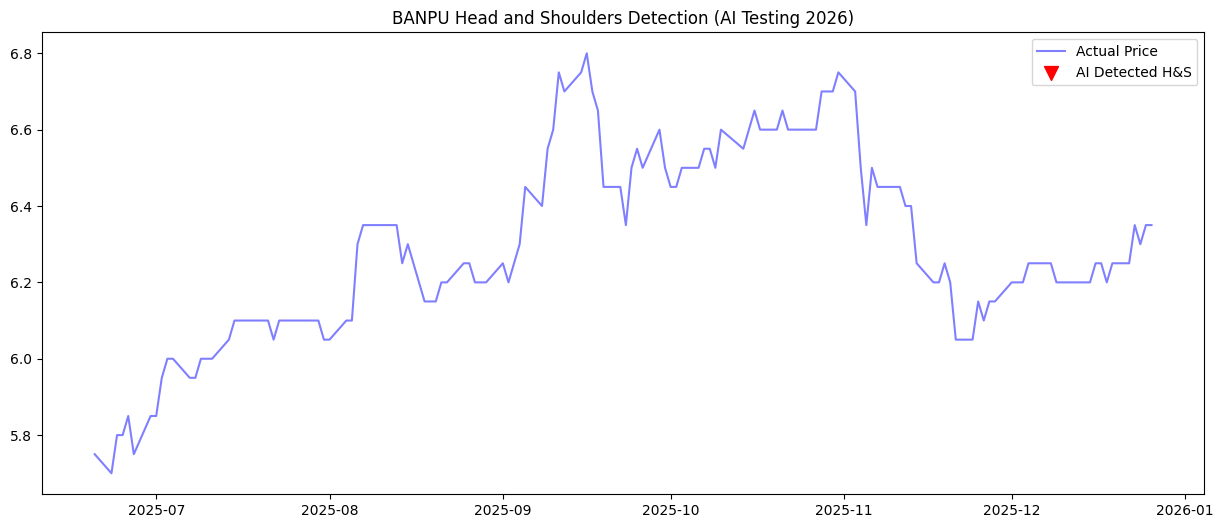

In [7]:
# ทำนายผลบน Test Set
predictions = model.predict(X_test)
# ดึงวันที่และราคาส่วนท้ายมาพล็อต
test_dates = df['date'].iloc[-len(y_test):].values
test_prices = df['close'].iloc[-len(y_test):].values

plt.figure(figsize=(15, 6))
plt.plot(test_dates, test_prices, label='Actual Price', color='blue', alpha=0.5)

# แสดงจุดที่ AI ตรวจพบ (ใช้ Threshold > 0.5 หรือปรับตามความมั่นใจ)
detected = np.where(predictions > 0.5)[0]
plt.scatter(test_dates[detected], test_prices[detected], color='red', marker='v', s=100, label='AI Detected H&S')

plt.title('BANPU Head and Shoulders Detection (AI Testing 2026)')
plt.legend()
plt.show()
